<a href="https://colab.research.google.com/github/MaiKau/MaiKau.github.io/blob/master/LSTM%E5%8F%B0%E5%8C%97%E7%A9%BA%E6%B1%99%E9%A0%90%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
tf.enable_eager_execution()

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [3]:
#上載 2.csv
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))



Saving dataset33.csv to dataset33.csv
User uploaded file "dataset33.csv" with length 117623 bytes


In [4]:
# 確認 2.csv 是否已上載
!ls *.* -l

# use Pandas to read 2.csv
import pandas as pd
df = pd.read_csv('dataset33.csv')
df.head()

-rw-r--r-- 1 root root 117623 Dec 19 02:10 dataset33.csv


,No,year,month,day,PM2.5,NO2,PM10,SO2,O3,CO,Td dew point,Temperature,WS,WD,StnPres
0,1,2016,1,1,29.051190,20.022500,58.894048,2.050217,34.137121,0.510857,15.2,19.0,3.9,50,1022.1
1,2,2016,1,2,34.834886,28.810952,69.396429,1.621950,30.830948,0.870893,16.3,18.9,0.6,120,1018.6
2,3,2016,1,3,26.243860,31.635714,45.623810,1.899167,28.177500,0.847381,17.7,19.1,1.1,60,1016.7
3,4,2016,1,4,19.920647,35.578261,38.157402,3.204167,24.224167,1.262833,19.2,20.6,0.4,180,1014.9
4,5,2016,1,5,18.552958,27.550983,37.766527,1.395036,17.291333,0.928394,18.8,20.7,1.2,70,1013.8


In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [6]:
TRAIN_SPLIT = 650
tf.random.set_random_seed(1)

uni_data = df['PM2.5']
uni_data.index = df['No']
uni_data.head()

No
1    29.051190
2    34.834886
3    26.243860
4    19.920647
5    18.552958
Name: PM2.5, dtype: float64

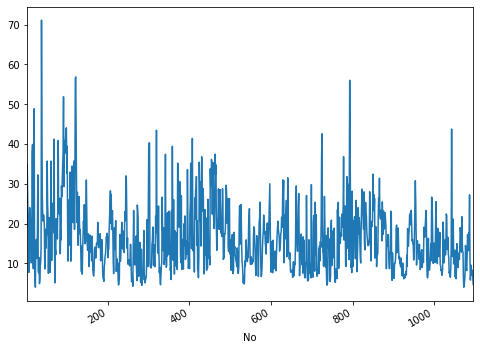

In [7]:
uni_data.plot(subplots=True)
uni_data = uni_data.values

In [0]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [0]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

In [11]:
BATCH_SIZE = 512
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(16, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [13]:
# EVALUATION_INTERVAL = 200
# EPOCHS = 10
EVALUATION_INTERVAL = 200
EPOCHS = 20

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/20
200/200 [==============================] - 12s 62ms/step - loss: 14.2061 - val_loss: 8.7080
Epoch 2/20
200/200 [==============================] - 8s 39ms/step - loss: 9.2816 - val_loss: 6.0310
Epoch 3/20
200/200 [==============================] - 8s 38ms/step - loss: 7.5230 - val_loss: 5.3555
Epoch 4/20
200/200 [==============================] - 8s 38ms/step - loss: 6.7041 - val_loss: 5.0475
Epoch 5/20
200/200 [==============================] - 8s 39ms/step - loss: 6.3793 - val_loss: 4.8347
Epoch 6/20
200/200 [==============================] - 8s 39ms/step - loss: 6.0765 - val_loss: 4.6678
Epoch 7/20
200/200 [==============================] - 8s 38ms/step - loss: 5.8057 - val_loss: 4.4829
Epoch 8/20
200/200 [==============================] - 8s 38ms/step - loss: 5.6221 - val_loss: 4.3864
Epoch 9/20
200/200 [==============================] - 8s 39ms/step - loss: 5.4820 - val_loss: 4.2883
Epoch 10/20
200/200 [=========================

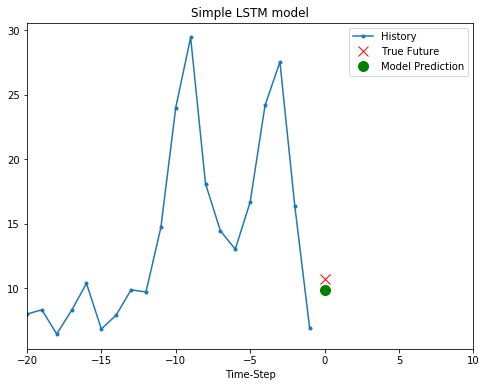

10.70136458
[9.887062]


In [14]:
for x, y in val_univariate.take(1):
  plot = show_plot([x[0].numpy(), y[0].numpy(), simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()
print(y[0].numpy())
print(simple_lstm_model.predict(x)[0])

In [15]:
features_considered = ['PM2.5','NO2','PM10','SO2','O3','CO','Td dew point','Temperature','WS','WD','StnPres']
features = df[features_considered]
features.index = df['No']
features.head()

,PM2.5,NO2,PM10,SO2,O3,CO,Td dew point,Temperature,WS,WD,StnPres
No,,,,,,,,,,,
1,29.051190,20.022500,58.894048,2.050217,34.137121,0.510857,15.2,19.0,3.9,50,1022.1
2,34.834886,28.810952,69.396429,1.621950,30.830948,0.870893,16.3,18.9,0.6,120,1018.6
3,26.243860,31.635714,45.623810,1.899167,28.177500,0.847381,17.7,19.1,1.1,60,1016.7
4,19.920647,35.578261,38.157402,3.204167,24.224167,1.262833,19.2,20.6,0.4,180,1014.9
5,18.552958,27.550983,37.766527,1.395036,17.291333,0.928394,18.8,20.7,1.2,70,1013.8


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd21e507c50>,
      dtype=object)

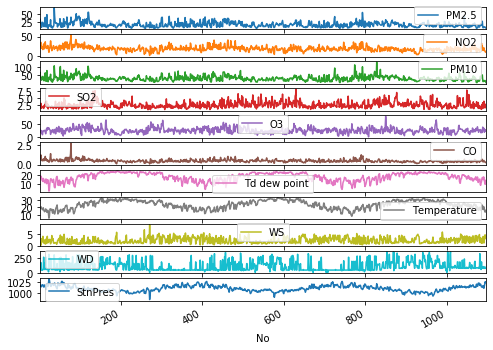

In [16]:
features.plot(subplots=True)

In [17]:
from sklearn.preprocessing import MinMaxScaler
dataset = features.values
values = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaled)
dataset = scaled


# scaled=np.reshape(scaled, [-1, 2])
# np.shape(scaled)

[[0.3733692  0.34206986 0.42169327 ... 0.42682925 0.11428571 0.7920151 ]
 [0.45951346 0.512446   0.5086483  ... 0.02439025 0.31428573 0.7184868 ]
 [0.33155584 0.56720775 0.31182173 ... 0.08536585 0.14285715 0.6785717 ]
 ...
 [0.06342506 0.18528767 0.09959919 ... 0.49999997 0.2        0.8655453 ]
 [0.03251391 0.15753973 0.04183735 ... 0.49999997 0.2        0.8235283 ]
 [0.01005368 0.1898224  0.00769621 ... 0.32926825 0.25714284 0.83823586]]


In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [0]:
past_history = 350
future_target = 1
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 0], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 0],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [0]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [21]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/20
200/200 [==============================] - 122s 609ms/step - loss: 0.0802 - val_loss: 0.0897
Epoch 2/20
200/200 [==============================] - 120s 600ms/step - loss: 0.0710 - val_loss: 0.0927
Epoch 3/20
200/200 [==============================] - 119s 594ms/step - loss: 0.0642 - val_loss: 0.0922
Epoch 4/20
200/200 [==============================] - 120s 598ms/step - loss: 0.0593 - val_loss: 0.1154
Epoch 5/20
200/200 [==============================] - 118s 592ms/step - loss: 0.0560 - val_loss: 0.1121
Epoch 6/20
200/200 [==============================] - 119s 594ms/step - loss: 0.0531 - val_loss: 0.1332
Epoch 7/20
200/200 [==============================] - 119s 594ms/step - loss: 0.0502 - val_loss: 0.1187
Epoch 8/20
200/200 [==============================] - 118s 589ms/step - loss: 0.0475 - val_loss: 0.1260
Epoch 9/20
200/200 [==============================] - 117s 586ms/step - loss: 0.0451 - val_loss: 0.1245
Epoch 10/20
200/200 [

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

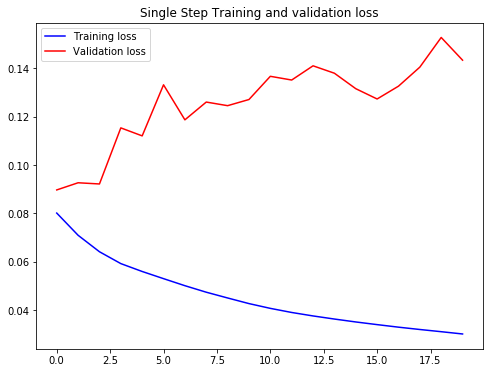

In [23]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

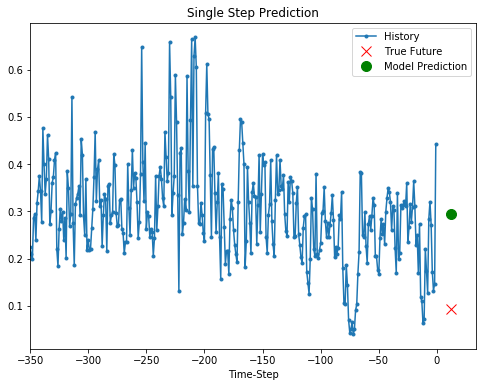

In [24]:
for x, y in val_data_single.take(1):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

In [0]:
future_target = 3
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 0], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 0],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [0]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [0]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

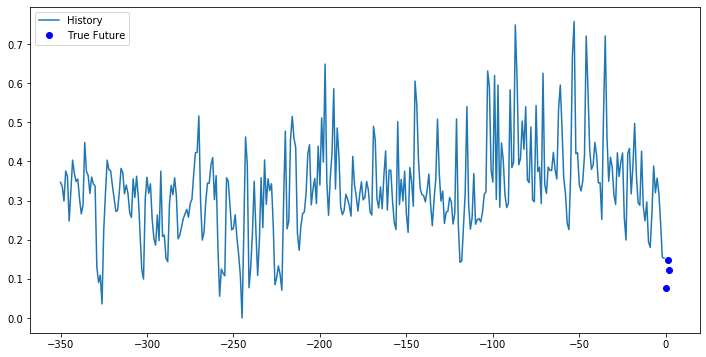

In [28]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [0]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(64,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(32, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(3))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [41]:
# EVALUATION_INTERVAL = 50
# EPOCHS = 5

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/20
200/200 [==============================] - 252s 1s/step - loss: 0.0835 - val_loss: 0.0743
Epoch 2/20
200/200 [==============================] - 248s 1s/step - loss: 0.0677 - val_loss: 0.0909
Epoch 3/20
200/200 [==============================] - 251s 1s/step - loss: 0.0595 - val_loss: 0.1114
Epoch 4/20
200/200 [==============================] - 253s 1s/step - loss: 0.0545 - val_loss: 0.1398
Epoch 5/20
200/200 [==============================] - 253s 1s/step - loss: 0.0493 - val_loss: 0.1367
Epoch 6/20
200/200 [==============================] - 254s 1s/step - loss: 0.0445 - val_loss: 0.1189
Epoch 7/20
200/200 [==============================] - 254s 1s/step - loss: 0.0407 - val_loss: 0.1201
Epoch 8/20
200/200 [==============================] - 254s 1s/step - loss: 0.0377 - val_loss: 0.1168
Epoch 9/20
200/200 [==============================] - 254s 1s/step - loss: 0.0350 - val_loss: 0.1147
Epoch 10/20
200/200 [===========================

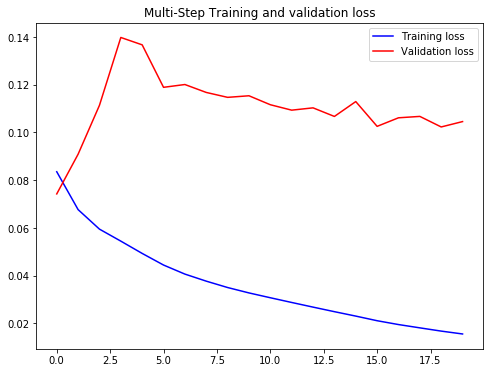

In [42]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

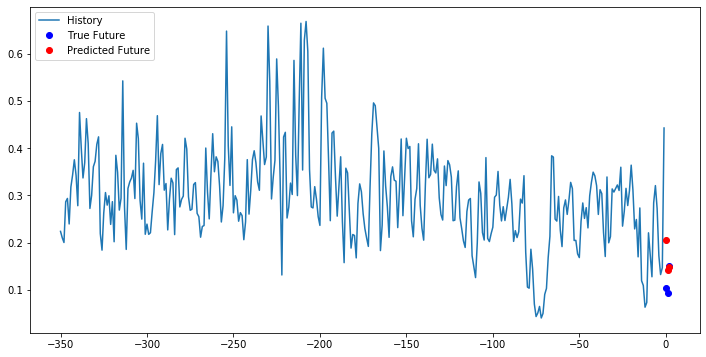

[17.81135  13.569187 13.920553]
tf.Tensor([10.932971 10.183333 14.033334], shape=(3,), dtype=float32)


In [43]:
for x, y in val_data_multi.take(1):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

# a=tf.reshape(y[0], [-1, 2])
# b=tf.reshape(x[0],[-1,2])
# c=tf.reshape(multi_step_model.predict(x)[0],[-1,2])


# new_a=scaler.inverse_transform(a)
a=(multi_step_model.predict(x)[0]-scaler.min_[0])/scaler.scale_[0]
b=(y[0]-scaler.min_[0])/scaler.scale_[0]
print((multi_step_model.predict(x)[0]-scaler.min_[0])/scaler.scale_[0])
print((y[0]-scaler.min_[0])/scaler.scale_[0])


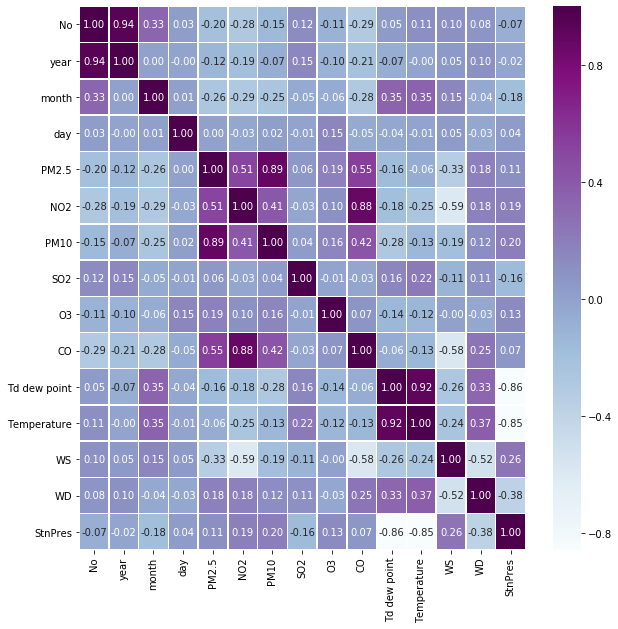

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import numpy as np
import pandas as pd
fig,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(), ax=ax, annot=True, linewidths=0.5, fmt= '.2f',cmap="BuPu")
plt.show()

In [45]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error
rmse = sqrt(mean_squared_error(a, b))
mse =mean_squared_error(a, b)
MAE =mean_absolute_error(a, b)
print('RMSE: %.2f' % rmse)
print('MSE: %.2f' % mse)
print('MAE: %.2f' % MAE)

RMSE: 4.43
MSE: 19.60
MAE: 3.46


In [47]:
multi_step_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 350, 64)           19456     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 31,971
Trainable params: 31,971
Non-trainable params: 0
_________________________________________________________________


In [0]:
multi_step_model.save('multi_step_model.h5')

In [53]:
from keras.models import load_model
global model
import h5py   

model = tf.contrib.keras.models.load_model('multi_step_model.h5')
model.summary()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 350, 64)           19456     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 31,971
Trainable params: 31,971
Non-trainable params: 0
_________________________________________________________________
